In [73]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import seaborn as sns
import os

In [74]:
import warnings
warnings.simplefilter("ignore")

# Load files

In [75]:
DATA_PATH = "BazaCut/"
paths = [DATA_PATH + "sentencesFilip/",
         DATA_PATH + "sentencesSebastian/",
         DATA_PATH + "sentencesMarcin/",
         DATA_PATH + "sentencesProfessor/"
]
no_of_sentences = 60
prefixes = ["N", "H", "A"]
Fs = 48000
neutral_sentences = []
happy_sentences = []
angry_sentences = []
import os
for i, path in enumerate(paths):
    filenames = os.listdir(path)
    for filename in filenames:
        label = filename.split("_")[0][-1]
        y, sr = librosa.load(path+filename, sr=None)
        match label:
            case "N":
                neutral_sentences.append(y)
            case "H":
                if i in [1, 2]:
                    angry_sentences.append(y)
                else:
                    happy_sentences.append(y)
            case "A":
                if i in [1, 2]:
                    happy_sentences.append(y)
                else:
                    angry_sentences.append(y)
            case _:
                print(f"Err {label = }")


# Sentences classification

## Podejście 1.

Jako że przy klasyfikacji słów okazało się że interpolowanie obliczonych wektorów na wektory o jednakowej długości daje zdecydowanie lepsze wyniki niż obliczanie jej średniej, to skupiono się najpierw na tym podejściu

In [76]:
def interpolate_to_length(array_2d, target_length):
    rows, original_length = array_2d.shape
    interpolated_array = np.zeros((rows, target_length))
    original_indices = np.linspace(0, original_length - 1, num=original_length)
    target_indices = np.linspace(0, original_length - 1, num=target_length)
    
    for i in range(rows):
        interpolated_array[i, :] = np.interp(target_indices, original_indices, array_2d[i, :])
    
    return interpolated_array

In [77]:
def test_classifiers(feature_vector, labels, chroma_name, accuracies):
    X_train, X_test, y_train, y_test = train_test_split(feature_vector, labels, test_size=0.5, random_state=0)
    
    # Normalize the features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    classifiers = [
        ("SVM", SVC(random_state=0)),
        ("Random Forest", RandomForestClassifier(random_state=0)),
        ("MLP", MLPClassifier(random_state=0))
    ]
    for clf in classifiers:
        clf[1].fit(X_train, y_train)
        y_pred = clf[1].predict(X_test)

        print(clf[0])
        accuracies.append(
            {
                "chroma_name": chroma_name,
                "algo": clf[0],
                "accuracy": accuracy_score(y_test, y_pred),
                "classification_report": classification_report(y_test, y_pred),
                "confusion_matrix": confusion_matrix(y_test, y_pred),
            }
        )
        print("Accuracy:", accuracy_score(y_test, y_pred))
        print()

In [78]:
all_words = [neutral_sentences, happy_sentences, angry_sentences]
labels_og = ["N", "H", "A"]
chroma_types ={
    "stft": {
        "func": librosa.feature.chroma_stft,
        "params": {},
    },
    "cqt": {
        "func": librosa.feature.chroma_cqt,
        "params": {},
    },
    "cens": {
        "func": librosa.feature.chroma_cens,
        "params": {},
    },
    "vqt": {
        "func": librosa.feature.chroma_vqt,
        "params": {"intervals": "equal"},
    }
}

accuracies = []

for chroma_name in chroma_types:
    print(f"*** {chroma_name.upper()} ***")
    feature_vector = []
    y = []
    for words, label in zip(all_words, labels_og):
        for audio in words:
            word_stft = chroma_types[chroma_name]["func"](y=audio, sr=sr, **chroma_types[chroma_name]["params"])
            feature_vector.append(interpolate_to_length(word_stft, 10).flatten())
            y.append(label)

    feature_vector = np.array(feature_vector)
    labels = np.array(y)

    test_classifiers(feature_vector, labels, chroma_name, accuracies)


*** STFT ***
SVM
Accuracy: 0.4444444444444444

Random Forest
Accuracy: 0.45555555555555555

MLP
Accuracy: 0.4888888888888889

*** CQT ***
SVM
Accuracy: 0.5777777777777777

Random Forest
Accuracy: 0.5333333333333333

MLP
Accuracy: 0.5111111111111111

*** CENS ***
SVM
Accuracy: 0.5666666666666667

Random Forest
Accuracy: 0.4777777777777778

MLP
Accuracy: 0.5222222222222223

*** VQT ***
SVM
Accuracy: 0.3888888888888889

Random Forest
Accuracy: 0.34444444444444444

MLP
Accuracy: 0.4111111111111111



In [79]:
accuracies.sort(key=lambda x: x["accuracy"], reverse=True)

for acc in accuracies:
    print(f"Chroma: {acc['chroma_name']}.\tAlgorithm: {acc['algo']}\tAccuracy: {acc['accuracy']}.")

Chroma: cqt.	Algorithm: SVM	Accuracy: 0.5777777777777777.
Chroma: cens.	Algorithm: SVM	Accuracy: 0.5666666666666667.
Chroma: cqt.	Algorithm: Random Forest	Accuracy: 0.5333333333333333.
Chroma: cens.	Algorithm: MLP	Accuracy: 0.5222222222222223.
Chroma: cqt.	Algorithm: MLP	Accuracy: 0.5111111111111111.
Chroma: stft.	Algorithm: MLP	Accuracy: 0.4888888888888889.
Chroma: cens.	Algorithm: Random Forest	Accuracy: 0.4777777777777778.
Chroma: stft.	Algorithm: Random Forest	Accuracy: 0.45555555555555555.
Chroma: stft.	Algorithm: SVM	Accuracy: 0.4444444444444444.
Chroma: vqt.	Algorithm: MLP	Accuracy: 0.4111111111111111.
Chroma: vqt.	Algorithm: SVM	Accuracy: 0.3888888888888889.
Chroma: vqt.	Algorithm: Random Forest	Accuracy: 0.34444444444444444.


### Best 3 results

In [80]:
def plot_best_results(accuracies, n):
    for acc in accuracies[:n]:
        print(f"Chroma: {acc['chroma_name']}")
        print(acc["classification_report"])
        ticks = ["Neutral", "Happy", "Anger"]
        
        # Plot the confusion matrix
        sns.heatmap(acc["confusion_matrix"], annot=True,fmt='d', cmap='YlGnBu',xticklabels=ticks, yticklabels=ticks )
        plt.ylabel('Prediction',fontsize=12)
        plt.xlabel('Actual',fontsize=12)
        plt.title('Confusion Matrix',fontsize=16)
        plt.show()
        print()

Chroma: cqt
              precision    recall  f1-score   support

           A       0.62      0.41      0.49        32
           H       0.62      0.62      0.62        32
           N       0.51      0.73      0.60        26

    accuracy                           0.58        90
   macro avg       0.59      0.59      0.57        90
weighted avg       0.59      0.58      0.57        90



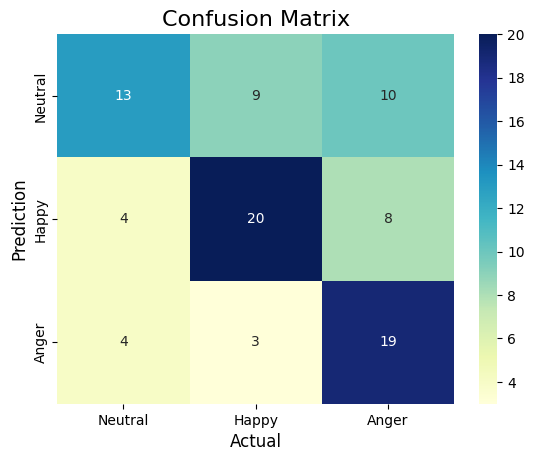


Chroma: cens
              precision    recall  f1-score   support

           A       0.60      0.28      0.38        32
           H       0.67      0.62      0.65        32
           N       0.49      0.85      0.62        26

    accuracy                           0.57        90
   macro avg       0.59      0.58      0.55        90
weighted avg       0.59      0.57      0.54        90



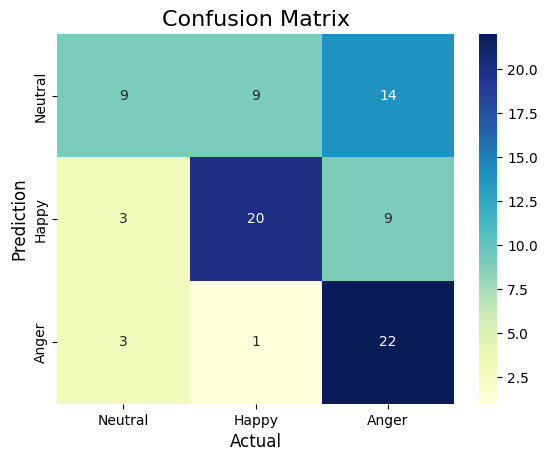


Chroma: cqt
              precision    recall  f1-score   support

           A       0.52      0.34      0.42        32
           H       0.62      0.56      0.59        32
           N       0.47      0.73      0.58        26

    accuracy                           0.53        90
   macro avg       0.54      0.55      0.53        90
weighted avg       0.54      0.53      0.52        90



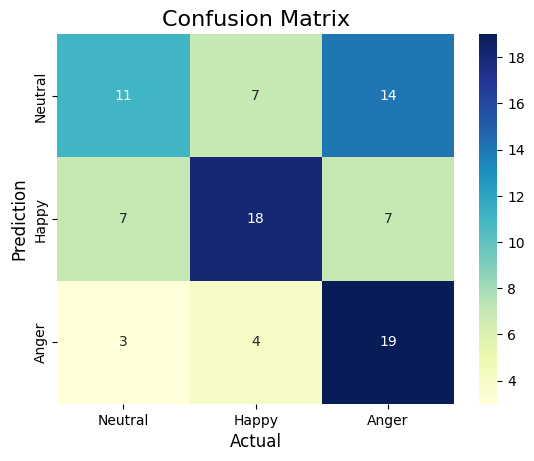

In [81]:
plot_best_results(accuracies, 3)

- Metoda interpolacji nie sprawdziła się w tym przypadku, najlepsze rezultaty wynosiły poniżej 60% skuteczności

## Podejście 2.
Powrót do metody obliczania średniej

In [82]:
accuracies = []

for chroma_name in chroma_types:
    print(f"*** {chroma_name.upper()} ***")
    feature_vector = []
    y = []
    for words, label in zip(all_words, labels_og):
        for audio in words:
            word_stft = chroma_types[chroma_name]["func"](y=audio, sr=sr, **chroma_types[chroma_name]["params"])
            feature_vector.append(word_stft.mean(axis=1).flatten())
            y.append(label)

    feature_vector = np.array(feature_vector)
    labels = np.array(y)

    test_classifiers(feature_vector, labels, chroma_name, accuracies)

accuracies.sort(key=lambda x: x["accuracy"], reverse=True)

for acc in accuracies:
    print(f"Chroma: {acc['chroma_name']}.\tAlgorithm: {acc['algo']}\tAccuracy: {acc['accuracy']}.")

*** STFT ***
SVM
Accuracy: 0.6111111111111112

Random Forest
Accuracy: 0.6111111111111112

MLP
Accuracy: 0.5888888888888889

*** CQT ***
SVM
Accuracy: 0.5888888888888889

Random Forest
Accuracy: 0.6444444444444445

MLP
Accuracy: 0.6333333333333333

*** CENS ***
SVM
Accuracy: 0.5444444444444444

Random Forest
Accuracy: 0.5555555555555556

MLP
Accuracy: 0.6

*** VQT ***
SVM
Accuracy: 0.6111111111111112

Random Forest
Accuracy: 0.5111111111111111

MLP
Accuracy: 0.5555555555555556

Chroma: cqt.	Algorithm: Random Forest	Accuracy: 0.6444444444444445.
Chroma: cqt.	Algorithm: MLP	Accuracy: 0.6333333333333333.
Chroma: stft.	Algorithm: SVM	Accuracy: 0.6111111111111112.
Chroma: stft.	Algorithm: Random Forest	Accuracy: 0.6111111111111112.
Chroma: vqt.	Algorithm: SVM	Accuracy: 0.6111111111111112.
Chroma: cens.	Algorithm: MLP	Accuracy: 0.6.
Chroma: stft.	Algorithm: MLP	Accuracy: 0.5888888888888889.
Chroma: cqt.	Algorithm: SVM	Accuracy: 0.5888888888888889.
Chroma: cens.	Algorithm: Random Forest	Accur

Chroma: cqt
              precision    recall  f1-score   support

           A       0.64      0.56      0.60        32
           H       0.63      0.69      0.66        32
           N       0.67      0.69      0.68        26

    accuracy                           0.64        90
   macro avg       0.65      0.65      0.65        90
weighted avg       0.64      0.64      0.64        90



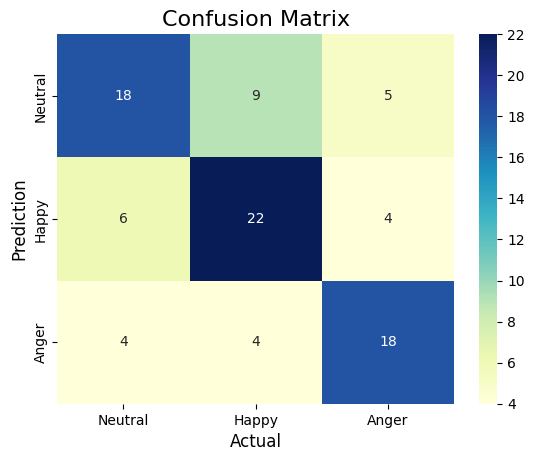


Chroma: cqt
              precision    recall  f1-score   support

           A       0.61      0.59      0.60        32
           H       0.72      0.56      0.63        32
           N       0.59      0.77      0.67        26

    accuracy                           0.63        90
   macro avg       0.64      0.64      0.63        90
weighted avg       0.64      0.63      0.63        90



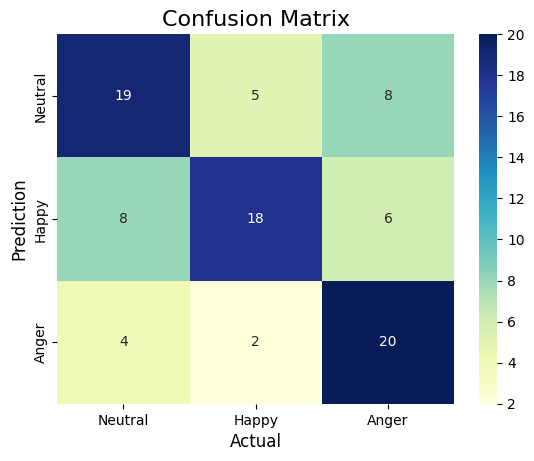


Chroma: stft
              precision    recall  f1-score   support

           A       0.53      0.25      0.34        32
           H       0.70      0.81      0.75        32
           N       0.55      0.81      0.66        26

    accuracy                           0.61        90
   macro avg       0.60      0.62      0.58        90
weighted avg       0.60      0.61      0.58        90



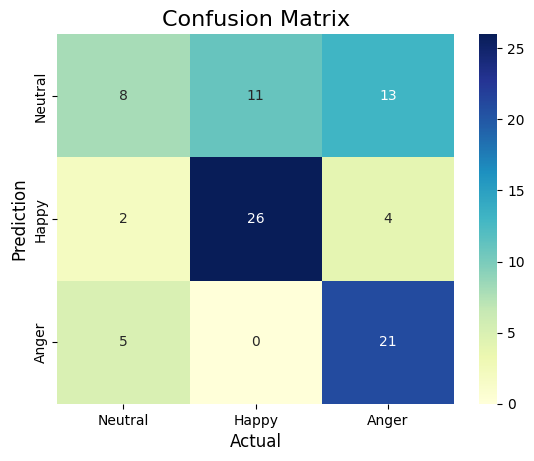

In [83]:
plot_best_results(accuracies, 3)

- Po powrocie do podejścia ze średnią udało się przekroczyć 60% skuteczności
- Algorytm `stft` zdecydowanie lepiej radzi sobie z rozpoznawaniem emocji niż klasyfikowaniem mówiącej osoby.
- Dobrze radzi sobie także `cqt`

## Podejście 3
Do średniej zdecydowałem się dodać także wariancję

In [84]:
accuracies = []

for chroma_name in chroma_types:
    print(f"*** {chroma_name.upper()} ***")
    feature_vector = []
    y = []
    for words, label in zip(all_words, labels_og):
        for audio in words:
            word_stft = chroma_types[chroma_name]["func"](y=audio, sr=sr, **chroma_types[chroma_name]["params"])
            feature_vector.append(np.array([word_stft.mean(axis=1), word_stft.var(axis=1)]).flatten())
            y.append(label)

    feature_vector = np.array(feature_vector)
    labels = np.array(y)

    test_classifiers(feature_vector, labels, chroma_name, accuracies)

accuracies.sort(key=lambda x: x["accuracy"], reverse=True)

for acc in accuracies[:5]:
    print(f"Chroma: {acc['chroma_name']}.\tAlgorithm: {acc['algo']}\tAccuracy: {acc['accuracy']}.")

*** STFT ***
SVM
Accuracy: 0.7

Random Forest
Accuracy: 0.6555555555555556

MLP
Accuracy: 0.7111111111111111

*** CQT ***
SVM
Accuracy: 0.6111111111111112

Random Forest
Accuracy: 0.6

MLP
Accuracy: 0.6333333333333333

*** CENS ***
SVM
Accuracy: 0.5888888888888889

Random Forest
Accuracy: 0.5666666666666667

MLP
Accuracy: 0.6333333333333333

*** VQT ***
SVM
Accuracy: 0.6111111111111112

Random Forest
Accuracy: 0.5444444444444444

MLP
Accuracy: 0.6222222222222222

Chroma: stft.	Algorithm: MLP	Accuracy: 0.7111111111111111.
Chroma: stft.	Algorithm: SVM	Accuracy: 0.7.
Chroma: stft.	Algorithm: Random Forest	Accuracy: 0.6555555555555556.
Chroma: cqt.	Algorithm: MLP	Accuracy: 0.6333333333333333.
Chroma: cens.	Algorithm: MLP	Accuracy: 0.6333333333333333.


Chroma: stft
              precision    recall  f1-score   support

           A       0.67      0.56      0.61        32
           H       0.82      0.84      0.83        32
           N       0.63      0.73      0.68        26

    accuracy                           0.71        90
   macro avg       0.71      0.71      0.71        90
weighted avg       0.71      0.71      0.71        90



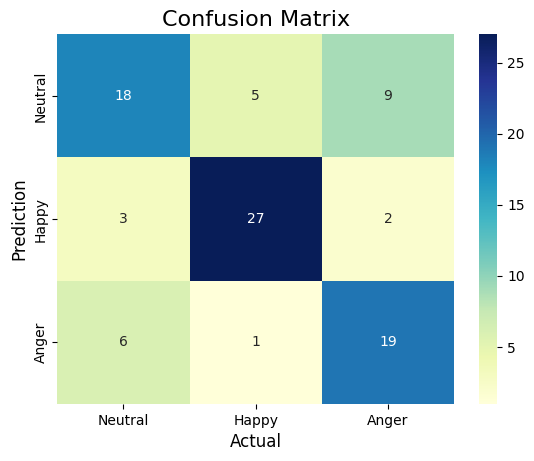


Chroma: stft
              precision    recall  f1-score   support

           A       0.75      0.47      0.58        32
           H       0.79      0.84      0.82        32
           N       0.58      0.81      0.68        26

    accuracy                           0.70        90
   macro avg       0.71      0.71      0.69        90
weighted avg       0.72      0.70      0.69        90



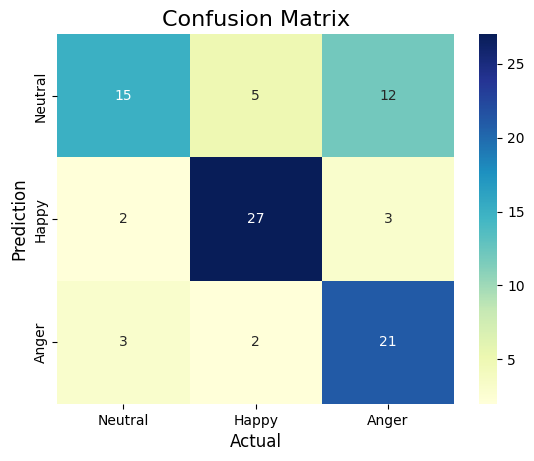


Chroma: stft
              precision    recall  f1-score   support

           A       0.75      0.38      0.50        32
           H       0.71      0.84      0.77        32
           N       0.56      0.77      0.65        26

    accuracy                           0.66        90
   macro avg       0.67      0.66      0.64        90
weighted avg       0.68      0.66      0.64        90



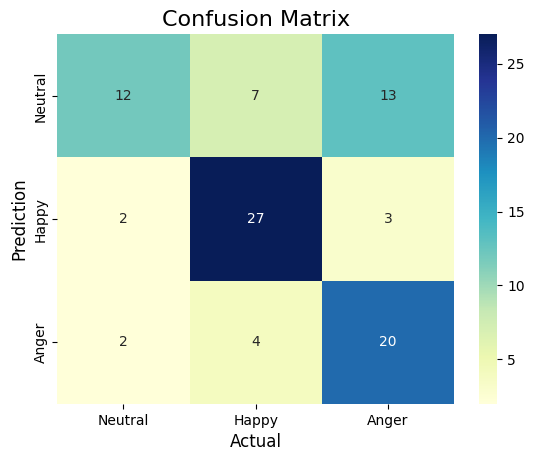

In [85]:
plot_best_results(accuracies, 3)

- Dzięki dodaniu tej kolejnej cechy udało się przekorczyć 70% accuracy
- Algorytm `stft` okazuje się zdecydowanie najlepszy

### Podejście 3b.

In [ ]:
accuracies = []

for chroma_name in chroma_types:
    print(f"*** {chroma_name.upper()} ***")
    feature_vector = []
    y = []
    for words, label in zip(all_words, labels_og):
        for audio in words:
            word_stft = chroma_types[chroma_name]["func"](y=audio, sr=sr, **chroma_types[chroma_name]["params"])
            feature_vector.append(np.concatenate([word_stft.mean(axis=1), word_stft.var(axis=1), np.quantile(word_stft, [0, 0.25, 0.5, 1], axis=1).flatten()]).flatten())
            y.append(label)

    feature_vector = np.array(feature_vector)
    labels = np.array(y)

    test_classifiers(feature_vector, labels, chroma_name, accuracies)

accuracies.sort(key=lambda x: x["accuracy"], reverse=True)

for acc in accuracies[:5]:
    print(f"Chroma: {acc['chroma_name']}.\tAlgorithm: {acc['algo']}\tAccuracy: {acc['accuracy']}.")

*** STFT ***
SVM
Accuracy: 0.7111111111111111

Random Forest
Accuracy: 0.6666666666666666

MLP
Accuracy: 0.6111111111111112

*** CQT ***
SVM
Accuracy: 0.5444444444444444

Random Forest
Accuracy: 0.6

MLP
Accuracy: 0.6444444444444445

*** CENS ***
SVM
Accuracy: 0.5666666666666667

Random Forest
Accuracy: 0.5666666666666667

MLP
Accuracy: 0.5666666666666667

*** VQT ***
SVM
Accuracy: 0.6222222222222222

Random Forest
Accuracy: 0.5666666666666667

MLP
Accuracy: 0.6222222222222222

Chroma: stft.	Algorithm: SVM	Accuracy: 0.7111111111111111.
Chroma: stft.	Algorithm: Random Forest	Accuracy: 0.6666666666666666.
Chroma: cqt.	Algorithm: MLP	Accuracy: 0.6444444444444445.
Chroma: vqt.	Algorithm: SVM	Accuracy: 0.6222222222222222.
Chroma: vqt.	Algorithm: MLP	Accuracy: 0.6222222222222222.


- Dodanie kwartyli oraaz wartości min i max nie zwiększyło skuteczności klasyfikacji

## Podejście 4
Jest to próba połączenia cech chromatycznych wyliczonych przy użyciu kilku algorytmów

In [89]:
accuracies = []

feature_vector = []
y = []
for words, label in zip(all_words, labels_og):
    for audio in words:
        word_vqt = librosa.feature.chroma_vqt(y=audio, sr=sr, intervals="equal")
        word_cqt = librosa.feature.chroma_cqt(y=audio, sr=sr)
        word_stft = librosa.feature.chroma_stft(y=audio, sr=sr)
        feature_vector.append(np.array([word_vqt.mean(axis=1), word_vqt.var(axis=1), word_cqt.mean(axis=1), word_cqt.var(axis=1), word_stft.mean(axis=1), word_stft.var(axis=1)]).flatten())
        y.append(label)

feature_vector = np.array(feature_vector)
labels = np.array(y)

test_classifiers(feature_vector, labels, "", accuracies)

accuracies.sort(key=lambda x: x["accuracy"], reverse=True)

for acc in accuracies:
    print(f"Algorithm: {acc['algo']}\tAccuracy: {acc['accuracy']}.")

SVM
Accuracy: 0.6555555555555556

Random Forest
Accuracy: 0.6666666666666666

MLP
Accuracy: 0.7333333333333333

Algorithm: MLP	Accuracy: 0.7333333333333333.
Algorithm: Random Forest	Accuracy: 0.6666666666666666.
Algorithm: SVM	Accuracy: 0.6555555555555556.


Chroma: 
              precision    recall  f1-score   support

           A       0.71      0.62      0.67        32
           H       0.81      0.78      0.79        32
           N       0.68      0.81      0.74        26

    accuracy                           0.73        90
   macro avg       0.73      0.74      0.73        90
weighted avg       0.74      0.73      0.73        90



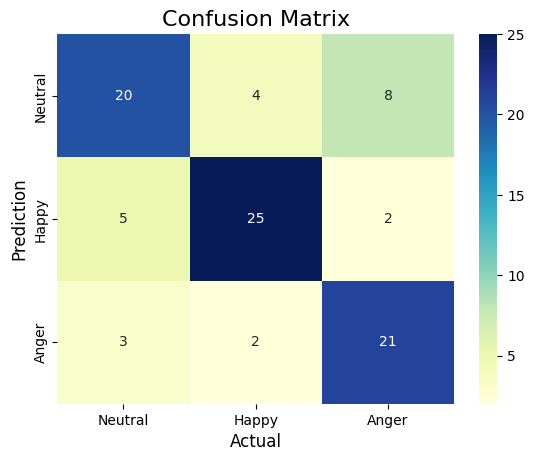


Chroma: 
              precision    recall  f1-score   support

           A       0.68      0.41      0.51        32
           H       0.74      0.81      0.78        32
           N       0.58      0.81      0.68        26

    accuracy                           0.67        90
   macro avg       0.67      0.68      0.65        90
weighted avg       0.68      0.67      0.65        90



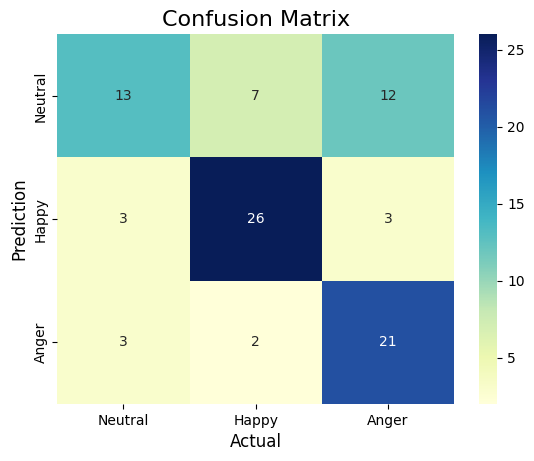


Chroma: 
              precision    recall  f1-score   support

           A       0.71      0.31      0.43        32
           H       0.81      0.81      0.81        32
           N       0.52      0.88      0.66        26

    accuracy                           0.66        90
   macro avg       0.68      0.67      0.63        90
weighted avg       0.69      0.66      0.63        90



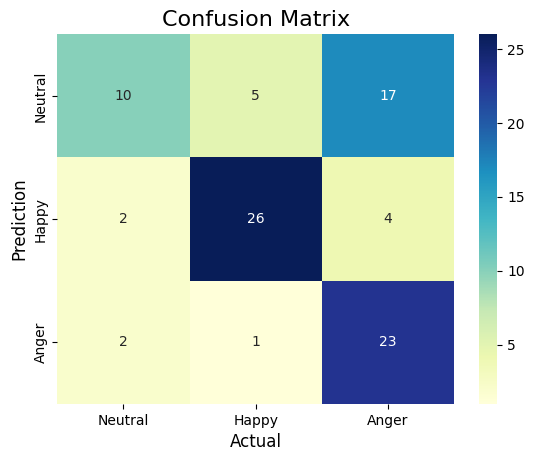

In [90]:
plot_best_results(accuracies, 3)

Połączenie cech obliczonych kilkoma metodami pozwoliło uzyskać niezłe wyniki. Nie są one jednak dużo większe niż te uzyskane wcześniej.